# Priority Flow Workflow Example

This script walks through a typical workflow for processing a DEM to ensure a fully
connected hydrologic drainage network. For more details on the Priority Flow tool
refer to Condon and Maxwell (2019): https://doi.org/10.1016/j.cageo.2019.01.020

This is a Python translation of the R vignette Workflow_Example.Rmd from the
PriorityFlow R package (https://github.com/lecondon/PriorityFlow).

The example uses the sample watershed from Condon and Maxwell (2019). The DEM and
mask files are provided with the PriorityFlow library.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Import from priority_flow package
from priority_flow import (
    init_queue,
    d4_traverse_b,
    load_dem,
    load_watershed_mask,
    load_river_mask,
    drainage_area,
    calc_subbasins,
    calc_stream_order,
    river_smooth,
    path_extract,
    slope_calc_standard,
    riv_slope,
)

## Background Information and Setup
Three inputs for domain processing:
1. The unprocessed DEM (Digital Elevation Model)
2. A mask of the watershed we are interested in
3. A mask of our desired drainage network

NOTE: The only required input is a DEM; the other two are optional depending
on how you would like to process things.

In [4]:
# Load test data
DEM = load_dem()
watershed_mask = load_watershed_mask()
river_mask = load_river_mask()

nx, ny = DEM.shape
print(f"Domain dimensions: nx={nx}, ny={ny}")
print(f"DEM elevation range: {DEM.min():.2f} to {DEM.max():.2f}")

Domain dimensions: nx=215, ny=172
DEM elevation range: 1029.73 to 3310.34


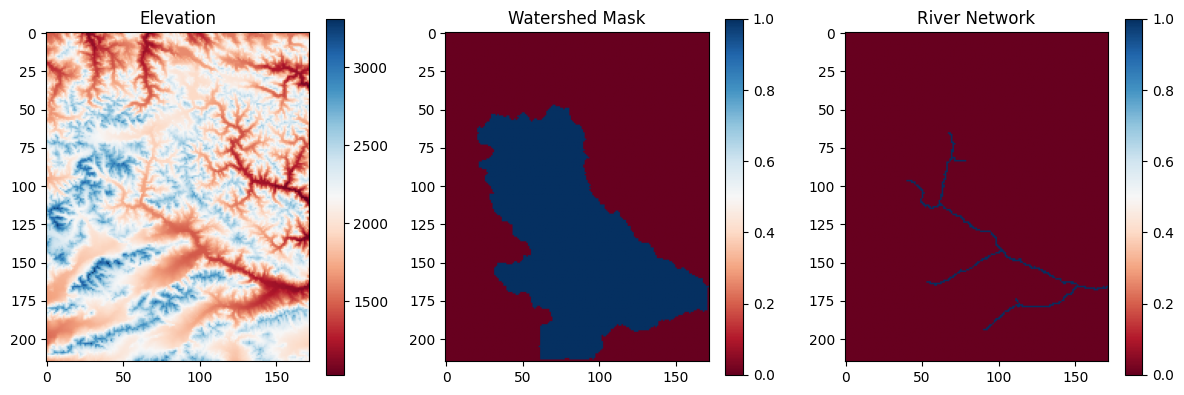

In [6]:
# Plot inputs
def _plot_inputs():
    """Plot the three input datasets."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(DEM, cmap='RdBu')
    axes[0].set_title("Elevation")
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(watershed_mask, cmap='RdBu')
    axes[1].set_title("Watershed Mask")
    plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].imshow(river_mask, cmap='RdBu')
    axes[2].set_title("River Network")
    plt.colorbar(im2, ax=axes[2])
    plt.tight_layout()
    plt.savefig("workflow_inputs.png", dpi=150)
    plt.show()
    plt.close()

_plot_inputs()

## Step 1: Processing the DEM
The priority flow algorithm traverses the raw DEM and ensures that every grid
cell has a pathway to exit along D4 drainage pathways (no unintended internal
sinks).

Outcomes:
1. A processed DEM with elevations adjusted to ensure drainage
2. A map of flow directions (1=down, 2=left, 3=up, 4=right)

Run one of the option blocks below (comment out the others). Option 4 has no code;
see Condon and Maxwell (2019) and Downwinding workflows 3 and 4 for that workflow.


### Option 1: 
If you have rectangular DEM and all border cells will be used as target exit points
In this case PriorityFlow will ensure that every grid cell in the domain drains to the edge
of the domain without identifying the desired drainage points a priori
setup target points

In [8]:
init = init_queue(DEM)

No init mask provided all border cells will be added to queue
No domain mask provided using entire domain
No border provided, setting border using domain mask


In [9]:
#process the DEM
trav_hs = d4_traverse_b(
    DEM,
    init["queue"].copy(),
    init["marked"].copy(),
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

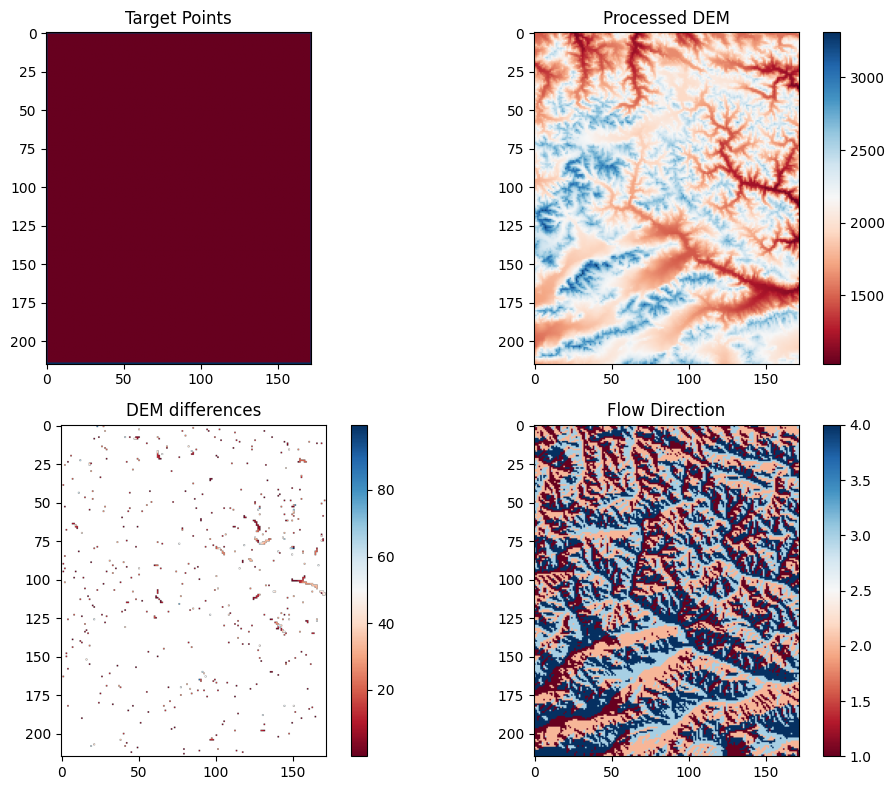

In [11]:
#some calculations for plotting
dem_diff = trav_hs["dem"] - DEM
dem_diff[dem_diff == 0] = np.nan
targets = init["marked"].copy()
targets[targets == 0] = np.nan

#plotting
def _plot_step1(trav_hs, dem_diff, targets):
    """Plot DEM processing results."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes[0, 0].imshow(np.where(np.isnan(targets), 0, 1), cmap='RdBu')
    axes[0, 0].set_title("Target Points")
    im1 = axes[0, 1].imshow(trav_hs["dem"], cmap='RdBu')
    axes[0, 1].set_title("Processed DEM")
    plt.colorbar(im1, ax=axes[0, 1])
    im2 = axes[1, 0].imshow(dem_diff, cmap='RdBu')
    axes[1, 0].set_title("DEM differences")
    plt.colorbar(im2, ax=axes[1, 0])
    im3 = axes[1, 1].imshow(trav_hs["direction"], cmap='RdBu')
    axes[1, 1].set_title("Flow Direction")
    plt.colorbar(im3, ax=axes[1, 1])
    plt.tight_layout()
    plt.savefig("workflow_step1.png", dpi=150)
    plt.show()
    plt.close()

_plot_step1(trav_hs, dem_diff, targets)

### Option 2: 
If you only want to process your DEM within a pre-defined watershed mask and all
border cells of that mask will be used as target exit points. Every point in the domain
drains to one of the edge points. Note: mask should have 1 for cells inside domain, 0 elsewhere.
setup target points


In [12]:
init = init_queue(DEM, domainmask=watershed_mask)

No init mask provided all border cells will be added to queue
No border provided, setting border using domain mask


In [13]:
#process the DEM
trav_hs = d4_traverse_b(
    DEM.copy(),
    init["queue"].copy(),
    init["marked"].copy(),
    mask=watershed_mask.copy(),
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

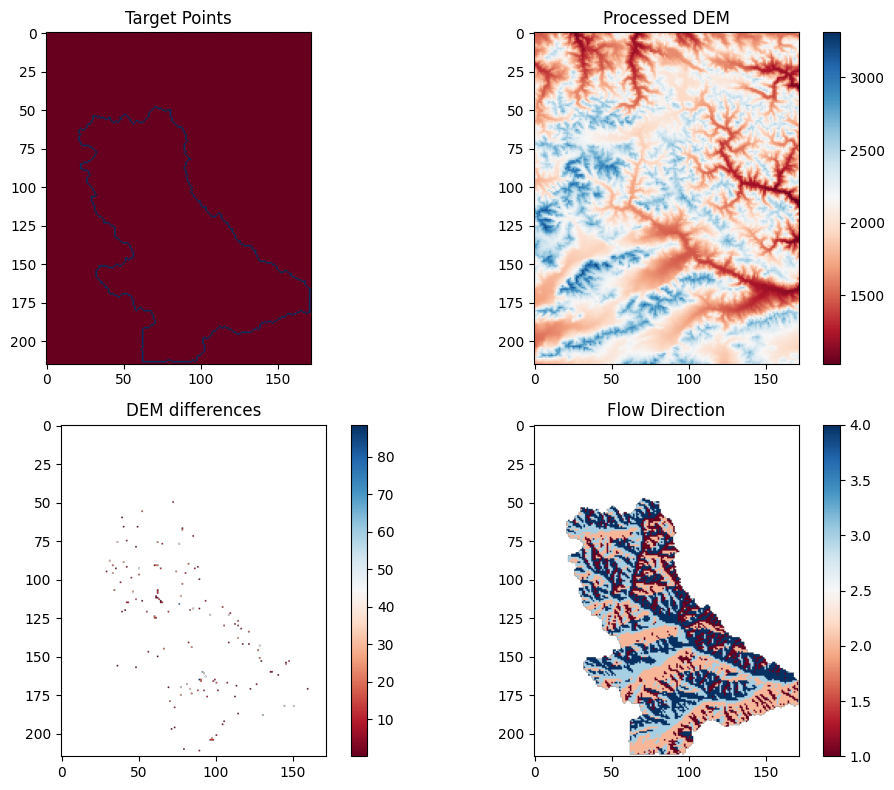

In [14]:
#some calculations for plotting
dem_diff = trav_hs["dem"] - DEM
dem_diff[dem_diff == 0] = np.nan
targets = init["marked"].copy()
targets[targets == 0] = np.nan
#plotting
_plot_step1(trav_hs, dem_diff, targets)

### Option 3: 
If you want to have more control over the set of target points used in the processing.
E.g. provide InitQueue with a river mask and a watershed mask so it identifies only those points
on the watershed mask that touch a boundary of your domain as target outlet points.
setup target points

In [15]:
init = init_queue(DEM, domainmask=watershed_mask, initmask=river_mask)

No border provided, setting border using domain mask


In [17]:
#process the DEM
trav_hs = d4_traverse_b(
    DEM.copy(),
    init["queue"].copy(),
    init["marked"].copy(),
    mask=watershed_mask.copy(),
    basins=init["basins"].copy(),
    epsilon=0,
    n_chunk=10,
)

inital queue: 3 Not splitting


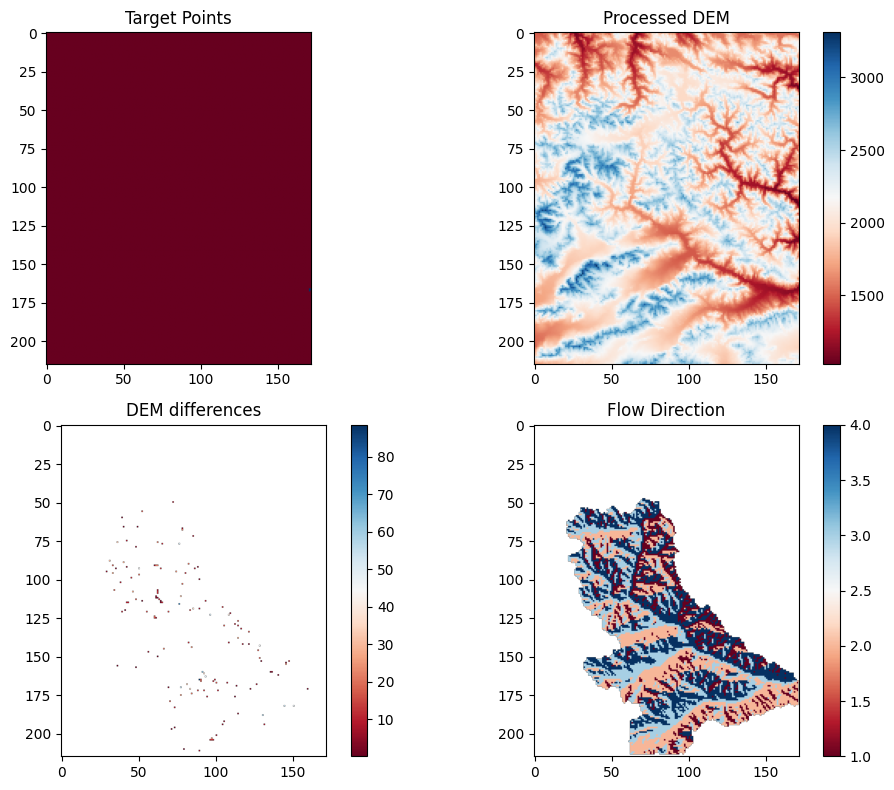

In [18]:
#some calculations for plotting
dem_diff = trav_hs["dem"] - DEM
dem_diff[dem_diff == 0] = np.nan
targets = init["marked"].copy()
targets[targets == 0] = np.nan
#plotting
_plot_step1(trav_hs, dem_diff, targets)

### Option 4: 
If you want to enforce flow paths along a pre-defined drainage network.
In that case you run a modified workflow: first process only the cells on the pre-defined
drainage network so they drain out of the domain; then a second pass so every grid cell
not on that network can drain to it. Described in Condon and Maxwell (2019) and
documented in Downwinding workflows 3 and 4. (No code block here.)

## Step 2: Smoothing along the drainage network
*Step 1* will ensure a drainage network which is fully connected and where all grid cells are guaranteed to drain to one of the target points (usually the edge of the domain). However, there can still be significant noise along the drainage path where jumps in the DEM can impact simulated flow performance. To address this you can do some additional smoothing along the river network. 

### Step 2.1: Calculate drainage areas
Before you can smooth your river network you need to know where it is. To do this you can use the flow direction file created in *Step 1* to calculate the drainage area for every grid cell in the domain.

In [19]:
area = drainage_area(
    trav_hs["direction"],
    mask=watershed_mask,
    printflag=False,
)

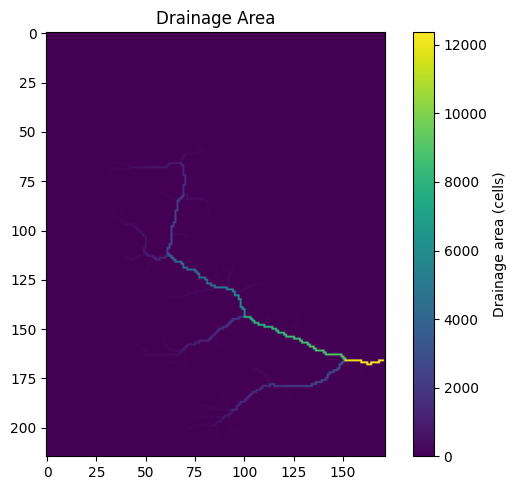

In [25]:
def _plot_drainage_area(area: np.ndarray) -> None:
    """Plot drainage area (like R: image.plot(area, main='drainage Area'))."""
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(area, cmap="viridis")
    ax.set_title("Drainage Area")
    plt.colorbar(im, ax=ax, label="Drainage area (cells)")
    plt.tight_layout()
    plt.savefig("workflow_drainage_area.png", dpi=150)
    plt.show()
    plt.close()

_plot_drainage_area(area)

*Note: In this example I used the watershed mask for the area calculations to be consistent with last DEM processing choices made. However, a mask is not required at this step if you did the DEM processing without applying a mask (i.e. as long as you have flow directions for the whole domain)*

## Step 2.2: Use a drainage area threshold to define a river network
Next you can use the flow direction file and the drainage areas to define a river network given a user specified drainage area threshold to define rivers (i.e. any cell with >=riv_th cells draining to it will count as a river)

In [20]:
# riv_th: cells with >= riv_th cells draining to it count as rivers
subbasin = calc_subbasins(
    trav_hs["direction"],
    area=area,
    mask=watershed_mask,
    riv_th=60,
    merge_th=0,
)

In [21]:
# Calculate stream order (optional)
stream_order = calc_stream_order(
    subbasin["summary"][:, 0],
    subbasin["summary"][:, 5],
    subbasin["segments"].copy(),
)

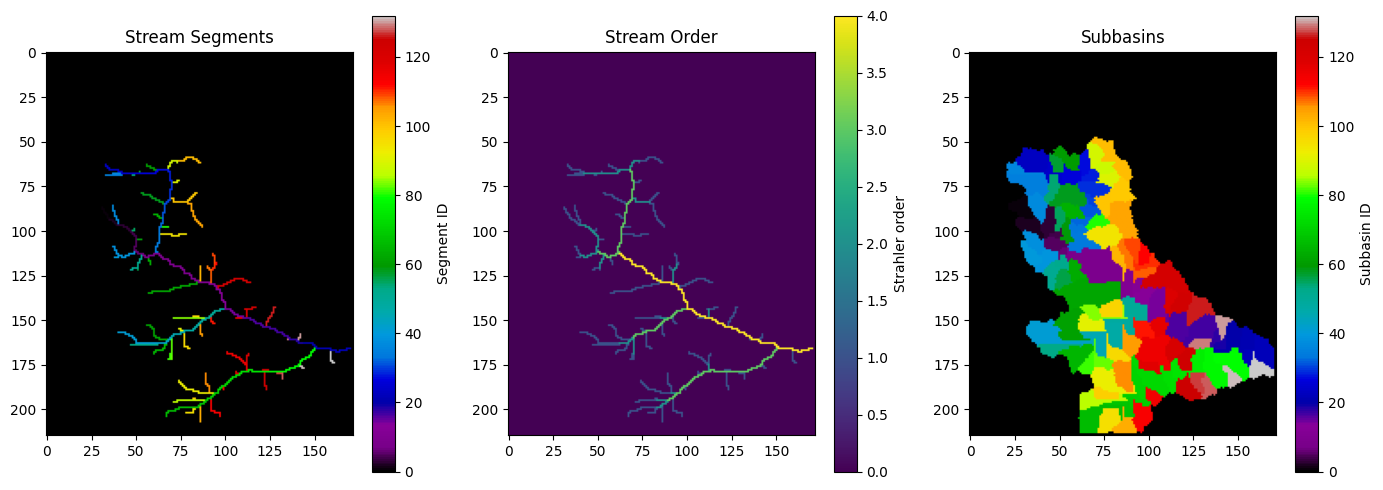

In [26]:
def _plot_stream_network(
    subbasin: dict,
    stream_order: dict,
) -> None:
    """Plot stream segments, stream order, and subbasins (like R par(mfrow=c(1,3)))."""
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    im0 = axes[0].imshow(subbasin["segments"], cmap="nipy_spectral")
    axes[0].set_title("Stream Segments")
    plt.colorbar(im0, ax=axes[0], label="Segment ID")
    im1 = axes[1].imshow(stream_order["order_mask"], cmap="viridis")
    axes[1].set_title("Stream Order")
    plt.colorbar(im1, ax=axes[1], label="Strahler order")
    im2 = axes[2].imshow(subbasin["subbasins"], cmap="nipy_spectral")
    axes[2].set_title("Subbasins")
    plt.colorbar(im2, ax=axes[2], label="Subbasin ID")
    plt.tight_layout()
    plt.savefig("workflow_stream_network.png", dpi=150)
    plt.show()
    plt.close()


_plot_stream_network(subbasin, stream_order)

*Note:Try changing the riv_th to change the density of the river network that is created. The merge threshold is used to lump together river segments with drainage areas below this threshold. Use help(CalcSubbasins) to learn more about the options for this function.*

Then, take a look at the resulting river network.

### Step 2.3: Smooth the DEM along river segments
Now you can apply smoothing along your river segments
This function requires:

1. The processed DEM from the PriorityFlow processing in Step 1
2. The flow directions from the PriorityFlow processing in Step 1
3. Information on the starting and ending points of every  river  segment calculated with the subbasin function
4. A map of the river segments from the subbasin function
5. A minimum elevation difference between designated stream cells and non stream cells that are draining to the stream segments (specified here as epsilon). 

This function will calculate the elevation difference from the start to the end of every  segment and apply a constant delta  along the length of the segment to get from the top to the bottom. Then it will traverse back  up the drainage network checking that in the stream adjustment process no stream cells were raised above their surrounding bank cells using the user specified epsilon value to enforce a difference of at least epsilon between bank and stream cells. IF a bank cell needs to be raised to meet the epsilon threshold the algorithm will continue traversing up the hill slope according to the flow direction file raising cells until every neighboring  cell can drain with the required epsilon criteria. 


In [22]:
riv_smooth_result = river_smooth(
    dem=trav_hs["dem"],
    direction=trav_hs["direction"],
    mask=watershed_mask,
    river_summary=subbasin["summary"],
    river_segments=subbasin["segments"],
    bank_epsilon=1,
)

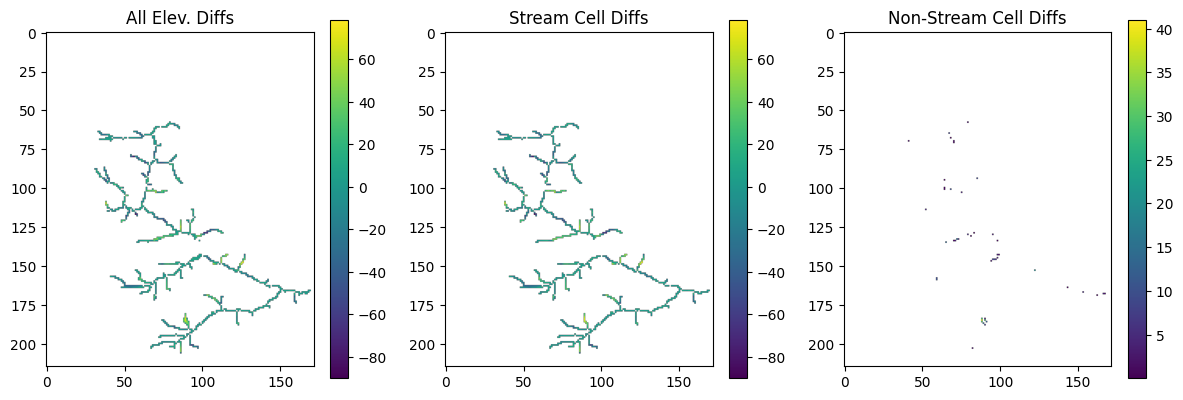

In [27]:
# Plot elevation differences from river smoothing
def _plot_river_smoothing():
    """Plot river smoothing results."""
    dif = riv_smooth_result["dem.adj"] - trav_hs["dem"]
    riv_mask = np.where(subbasin["segments"] > 0, 1, 0)
    hill_mask = 1 - riv_mask
    dif_hill = dif * hill_mask
    dif_riv = dif * riv_mask

    dif_plot = np.where(dif == 0, np.nan, dif)
    dif_riv_plot = np.where(dif_riv == 0, np.nan, dif_riv)
    dif_hill_plot = np.where(dif_hill == 0, np.nan, dif_hill)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(dif_plot)
    axes[0].set_title("All Elev. Diffs")
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(dif_riv_plot)
    axes[1].set_title("Stream Cell Diffs")
    plt.colorbar(im1, ax=axes[1])
    if np.any(~np.isnan(dif_hill_plot)):
        im2 = axes[2].imshow(dif_hill_plot)
        axes[2].set_title("Non-Stream Cell Diffs")
        plt.colorbar(im2, ax=axes[2])
    plt.tight_layout()
    plt.savefig("workflow_step2_smoothing.png", dpi=150)
    plt.show()
    plt.close()

_plot_river_smoothing()